In [1]:
# naive prediction model
# uses only elo in a hard coded logic model

import archives_manager

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [3]:
# hard-coded logic naive model

def predict_win(archived_game, player_name):
    elo = archives_manager.get_elo(archived_game, player_name)

    if elo['Player'] > elo['Opponent']:
        return 1
    else:
        return 0

In [4]:
def get_player_analysis(player_name, num_games):
    recent_archive = archives_manager.getMostRecentGames(player_name, num_games, filter_func=archives_manager.build_archive_filter(rated=True, time_class='rapid', exclude_draws=True, max_elo_diff=150))

    lst = []

    for archived_game in recent_archive:
        pred = predict_win(archived_game, player_name)
        actual = archives_manager.get_won(archived_game, player_name)

        elo = archives_manager.get_elo(archived_game, player_name)

        accuracy = archives_manager.get_accuracy(archived_game, player_name)

        lst.append({
            'player_elo': elo['Player'],
            'opp_elo': elo['Opponent'],
            'elo_diff': elo['Player'] - elo['Opponent'],
            'won': actual,
            'won_predict': pred,
            'player_acc': accuracy['Player'] if accuracy else None,
            'opp_acc': accuracy['Opponent'] if accuracy else None,
            'acc_diff': (accuracy['Player'] - accuracy['Opponent']) if accuracy else None
        })

    df = pd.DataFrame(lst)

    return df, recent_archive

In [5]:
def analysis_prediction_stats(df):
    TP = len(df[(df['won_predict'] == 1) & (df['won'] == 1)])
    TN = len(df[(df['won_predict'] == 0) & (df['won'] == 0)])
    FP = len(df[(df['won_predict'] == 1) & (df['won'] == 0)])
    FN = len(df[(df['won_predict'] == 0) & (df['won'] == 1)])

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'N': TP + TN + FP + FN,
        'accuracy': accuracy
    }

In [6]:
players = [
    'BIG_TONKA_T',
    'UnderTheBeer',
    'Dandres0_0',
    'Ale9800',
    'MrOGH'
]

def get_average_elo(archive, player_name):
    n = len(archive)
    avg = 0

    for archived_game in archive:
        avg += (archives_manager.get_elo(archived_game, player_name)['Player'] / n)

    return avg

analyses = []
stats_list = []

for player_name in players:
    df, recent_archive = get_player_analysis(player_name, num_games=1000)
    
    player_info = {
        'Name': player_name,
        'Current Rating': archives_manager.get_elo(recent_archive[0], player_name)['Player'],
        'Average Rating': round(get_average_elo(recent_archive, player_name))
    }

    player_info.update(analysis_prediction_stats(df))

    analyses.append({
        'player_name': player_name,
        'stats': player_info,
        'data': df,
        'archive': recent_archive
    })

    stats_list.append(player_info)

stats_df = pd.DataFrame(stats_list)

print('overall average accuracy', round(np.mean(stats_df['accuracy']), 3))

stats_df

overall average accuracy 0.663


,Name,Current Rating,Average Rating,TP,TN,FP,FN,N,accuracy
0,BIG_TONKA_T,1501,1384,369,320,169,142,1000,0.689
1,UnderTheBeer,1424,1343,349,308,178,165,1000,0.657
2,Dandres0_0,1455,1498,351,319,175,155,1000,0.670
3,Ale9800,1467,1488,336,302,189,173,1000,0.638
4,MrOGH,1362,1325,338,324,170,168,1000,0.662


In [7]:
for analysis in analyses:
    print(analysis['player_name'])
    print(analysis['data'])

BIG_TONKA_T
     player_elo  opp_elo  elo_diff  won  won_predict  player_acc  opp_acc  \
0          1501     1434        67    1            1       86.49    72.91   
1          1494     1437        57    1            1       88.89    76.97   
2          1487     1493        -6    1            0       85.90    69.75   
3          1478     1555       -77    1            0       82.67    77.67   
4          1468     1459         9    1            1       87.82    71.88   
5          1460     1523       -63    1            0       78.04    70.57   
6          1450     1380        70    0            1       63.24    67.50   
7          1460     1524       -64    0            0       56.99    81.04   
8          1467     1458         9    0            1         NaN      NaN   
9          1476     1493       -17    0            0       75.83    81.18   
10         1484     1466        18    1            1       78.41    66.92   
11         1476     1581      -105    0            0       70.55

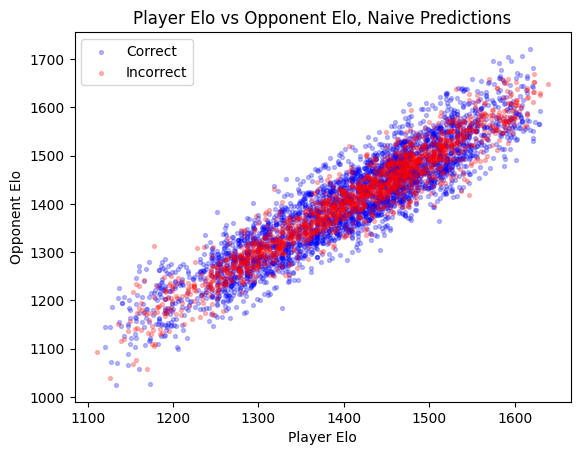

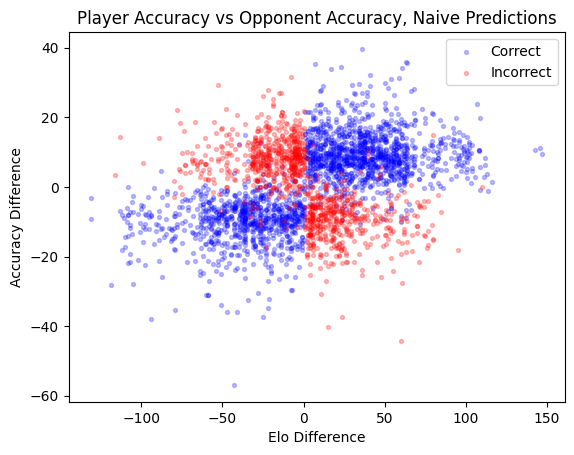

In [10]:
data_list = [analysis['data'] for analysis in analyses]
df = pd.concat(data_list)

correct_df = df[df['won'] == df['won_predict']]
incorrect_df = df[df['won'] != df['won_predict']]

plt.scatter(correct_df['player_elo'], correct_df['opp_elo'], color='blue', s=8, alpha=0.25, label='Correct')
plt.scatter(incorrect_df['player_elo'], incorrect_df['opp_elo'], color='red', s=8, alpha=0.25, label='Incorrect')

plt.xlabel('Player Elo')
plt.ylabel('Opponent Elo')
plt.title('Player Elo vs Opponent Elo, Naive Predictions')
plt.legend()
plt.show()

plt.scatter(correct_df['elo_diff'], correct_df['acc_diff'], color='blue', s=8, alpha=0.25, label='Correct')
plt.scatter(incorrect_df['elo_diff'], incorrect_df['acc_diff'], color='red', s=8, alpha=0.25, label='Incorrect')

plt.xlabel('Elo Difference')
plt.ylabel('Accuracy Difference')
plt.title('Player Accuracy vs Opponent Accuracy, Naive Predictions')
plt.legend()
plt.show()